# Capstone Project - Market Price Prediction

In [2]:
import pandas as pd
import numpy as np

from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set_style('whitegrid')

import pandas_ta as ta

from ta.volatility import BollingerBands
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.momentum import StochRSIIndicator

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import math

## Load stock data

In [1333]:
# Stocks selected from S&P500 index
# TODO load data for 5 last years according to proposal
stock_list = ['NFLX', 'EPAM', 'AAPL']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1334]:
# TODO improve data loading with bulk loading available from yfinance
company_list = [NFLX, EPAM, AAPL]
company_name = ["Netflix", "EPAM", "Apple"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2022-04-25,161.119995,163.169998,158.460007,162.880005,162.641037,96046400,Apple
2022-04-26,162.250000,162.339996,156.720001,156.800003,156.569962,95623200,Apple
2022-04-27,155.910004,159.789993,155.380005,156.570007,156.340302,88063200,Apple
2022-04-28,159.250000,164.520004,158.929993,163.639999,163.399918,130216800,Apple
2022-04-29,161.839996,166.199997,157.250000,157.649994,157.418701,131587100,Apple
2022-05-02,156.710007,158.229996,153.270004,157.960007,157.728256,123055300,Apple
2022-05-03,158.149994,160.710007,156.320007,159.479996,159.246017,88966500,Apple
2022-05-04,159.669998,166.479996,159.259995,166.020004,165.776428,108256500,Apple
2022-05-05,163.850006,164.080002,154.949997,156.770004,156.540009,130525300,Apple


In [1335]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3.780000e+03
mean,239.401256,242.873161,235.692177,239.357230,238.934964,4.277877e+07
std,173.593705,176.089352,170.751458,173.392916,173.809891,6.359355e+07
min,35.724998,35.875000,35.500000,35.547501,33.670544,4.570000e+04
25%,99.857500,100.577499,97.712500,99.879997,99.879997,4.285500e+05
50%,178.415001,180.854996,176.169998,178.425003,178.385002,5.923250e+06
75%,356.400009,362.410011,350.502502,356.794991,356.794991,8.372150e+07
max,725.400024,725.400024,711.650024,717.489990,717.489990,4.265100e+08


In [1336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3780 entries, 2017-05-08 to 2022-05-06
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3780 non-null   float64
 1   High          3780 non-null   float64
 2   Low           3780 non-null   float64
 3   Close         3780 non-null   float64
 4   Adj Close     3780 non-null   float64
 5   Volume        3780 non-null   int64  
 6   company_name  3780 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 236.2+ KB


## Sock prices

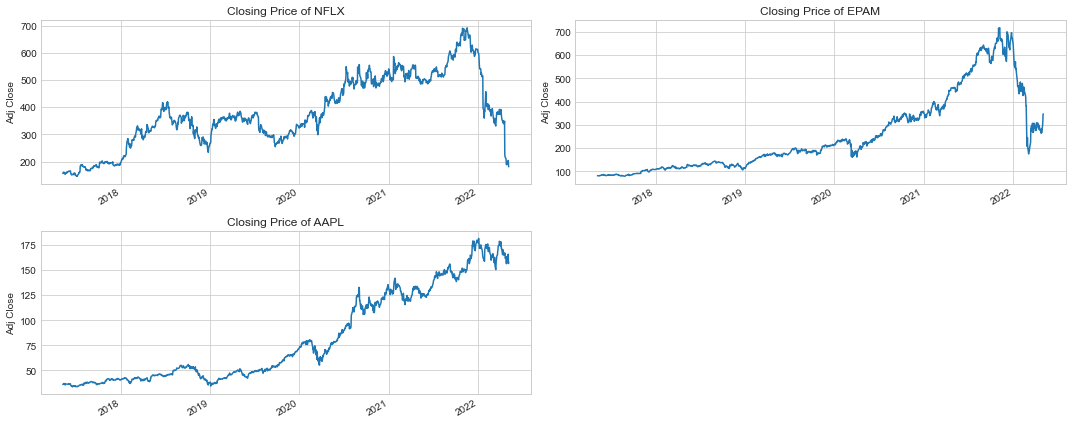

In [1337]:
# Pot stock market prices
plt.figure(figsize=(15, 6))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {stock_list[i - 1]}")
    
plt.tight_layout()


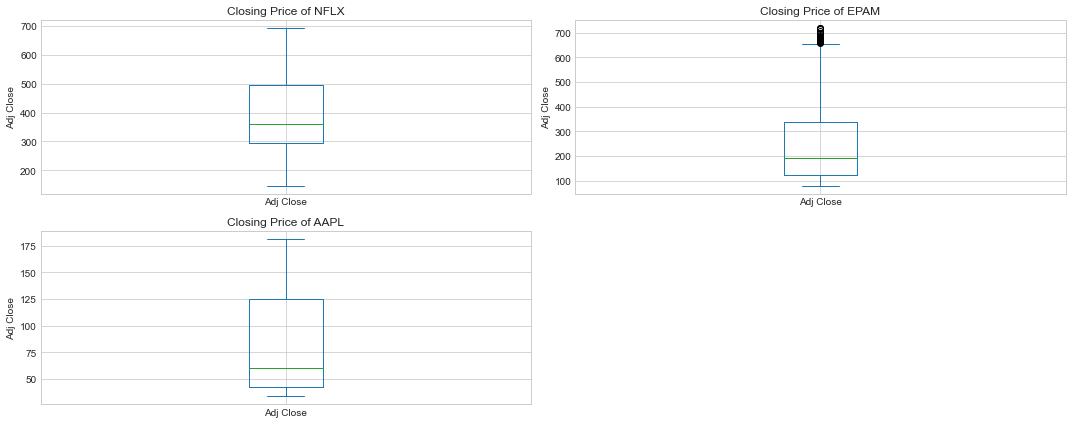

In [1338]:
# Pot stock market volume box plot
plt.figure(figsize=(15, 6))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot(kind="box")
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {stock_list[i - 1]}")
    
plt.tight_layout()

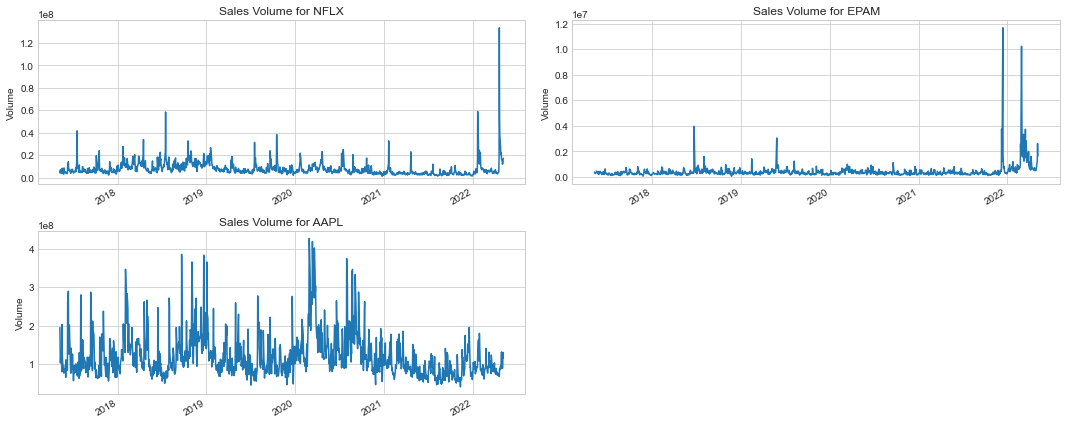

In [1339]:
# Pot stock market volume
plt.figure(figsize=(15, 6))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {stock_list[i - 1]}")
    
plt.tight_layout()

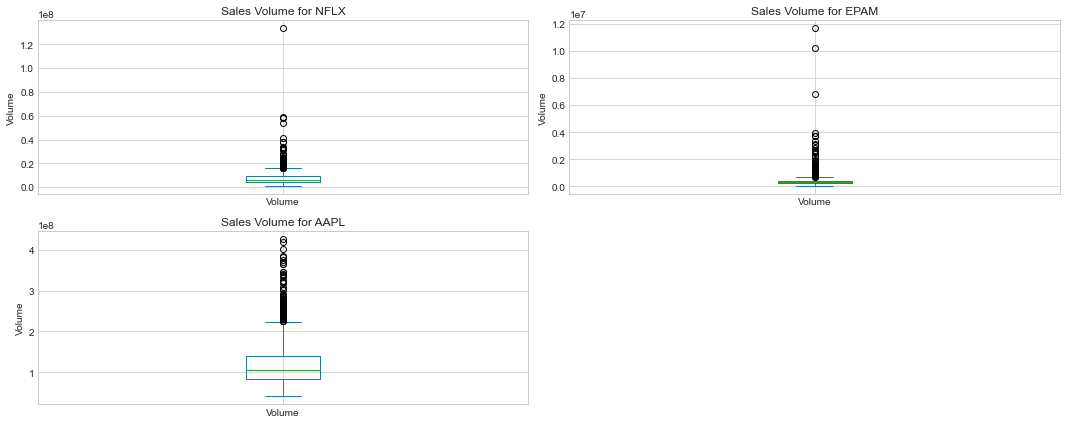

In [1340]:
# Pot stock market volume box plot
plt.figure(figsize=(15, 6))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot(kind="box")
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {stock_list[i - 1]}")
    
plt.tight_layout()

## Exploratory Data Analysis

### Moving average

In [1341]:
ma_day = [8, 21, 55]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

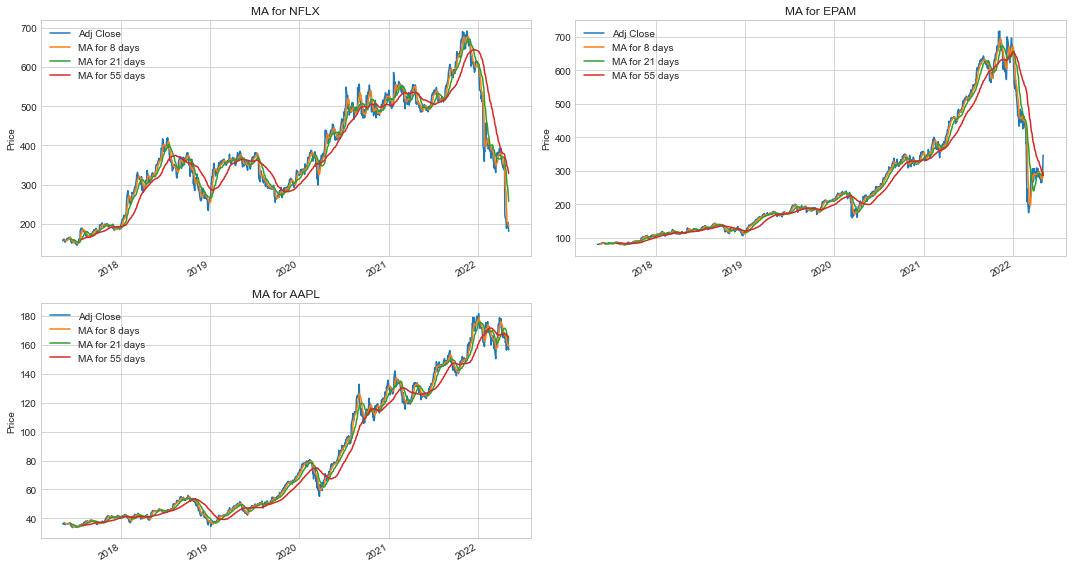

In [1342]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['Adj Close', 'MA for 8 days', 'MA for 21 days', 'MA for 55 days']].plot(ax=ax)
    plt.ylabel('Price')
    plt.xlabel(None)
    plt.title(f"MA for {stock_list[i - 1]}")
    
fig.tight_layout()

### Exponential moving average

In [1343]:
ema_day = [8, 21, 55]

for ema in ema_day:
    for company in company_list:
        column_name = f"EMA for {ema} days"
        company[column_name] = company['Adj Close'].ewm(span=ema, adjust=False).mean()

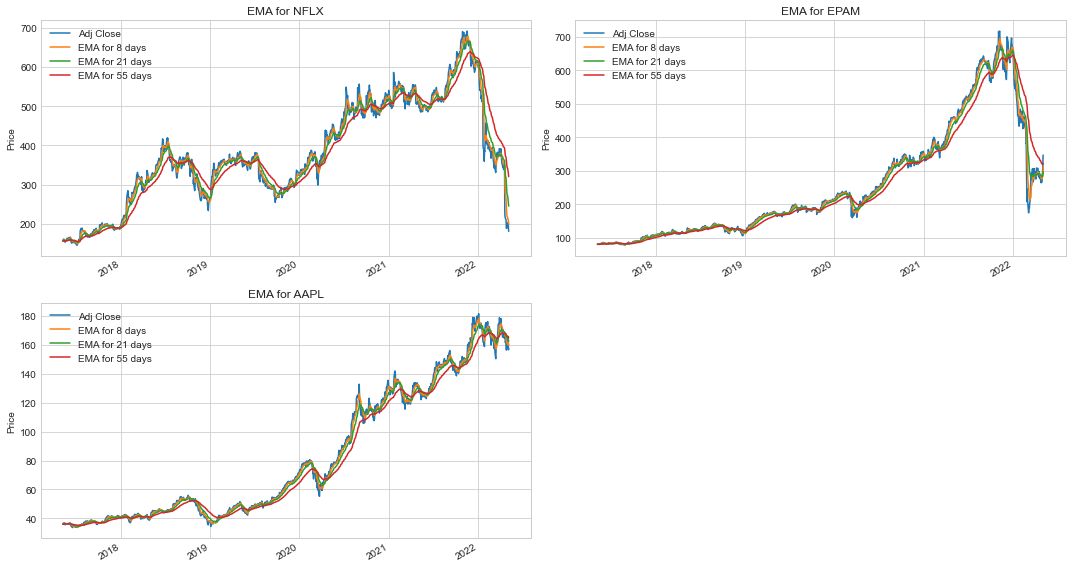

In [1344]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['Adj Close', 'EMA for 8 days', 'EMA for 21 days', 'EMA for 55 days']].plot(ax=ax)
    plt.ylabel('Price')
    plt.xlabel(None)
    plt.title(f"EMA for {stock_list[i - 1]}")
    
fig.tight_layout()

### MACD

In [1345]:
for company in company_list:
    company.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

company.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name,MA for 8 days,MA for 21 days,MA for 55 days,EMA for 8 days,EMA for 21 days,EMA for 55 days,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,,,,,,
2022-05-02,156.710007,158.229996,153.270004,157.960007,157.728256,123055300,Apple,160.228331,166.154920,165.804754,160.356735,163.942262,165.838044,-2.740870,-1.104273,-1.636597
2022-05-03,158.149994,160.710007,156.320007,159.479996,159.246017,88966500,Apple,159.362103,165.449766,165.638452,160.109909,163.515331,165.602614,-2.745405,-0.887047,-1.858359
2022-05-04,159.669998,166.479996,159.259995,166.020004,165.776428,108256500,Apple,159.890078,164.859205,165.586528,161.369135,163.720885,165.608822,-2.195962,-0.270082,-1.925879
2022-05-05,163.850006,164.080002,154.949997,156.770004,156.540009,130525300,Apple,159.127449,163.989531,165.295683,160.295996,163.068078,165.284936,-2.478352,-0.441978,-2.036374
2022-05-06,156.009995,159.440002,154.179993,157.279999,157.279999,116055700,Apple,159.216204,163.308678,165.022649,159.625775,162.541889,164.999045,-2.630672,-0.475438,-2.155234


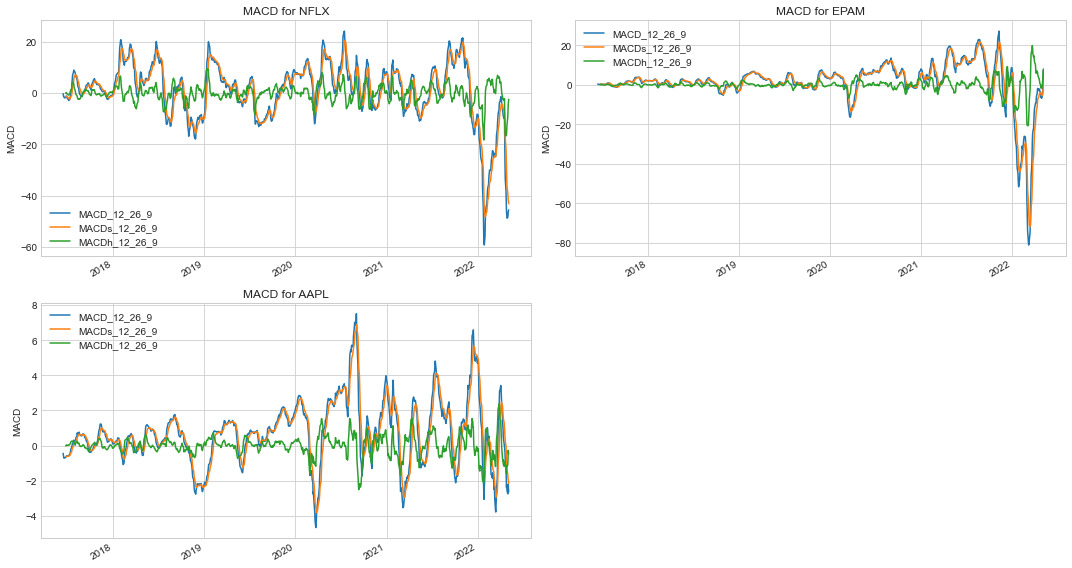

In [1346]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9']].plot(ax=ax)
    plt.ylabel('MACD')
    plt.xlabel(None)
    plt.title(f"MACD for {stock_list[i - 1]}")
    
fig.tight_layout()

### Bollinger Bands

In [1347]:
for company in company_list:
    indicator_bb = BollingerBands(close=company['Adj Close'], window=20, window_dev=2)
    company['BB_BBM'] = indicator_bb.bollinger_mavg()
    company['BB_BBH'] = indicator_bb.bollinger_hband()
    company['BB_BBL'] = indicator_bb.bollinger_lband()

company.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name,MA for 8 days,MA for 21 days,MA for 55 days,EMA for 8 days,EMA for 21 days,EMA for 55 days,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BB_BBM,BB_BBH,BB_BBL
Date,,,,,,,,,,,,,,,,,,,
2022-05-02,156.710007,158.229996,153.270004,157.960007,157.728256,123055300,Apple,160.228331,166.154920,165.804754,160.356735,163.942262,165.838044,-2.740870,-1.104273,-1.636597,165.759953,177.518981,154.000925
2022-05-03,158.149994,160.710007,156.320007,159.479996,159.246017,88966500,Apple,159.362103,165.449766,165.638452,160.109909,163.515331,165.602614,-2.745405,-0.887047,-1.858359,164.813344,175.412123,154.214564
2022-05-04,159.669998,166.479996,159.259995,166.020004,165.776428,108256500,Apple,159.890078,164.859205,165.586528,161.369135,163.720885,165.608822,-2.195962,-0.270082,-1.925879,164.362007,173.940396,154.783619
2022-05-05,163.850006,164.080002,154.949997,156.770004,156.540009,130525300,Apple,159.127449,163.989531,165.295683,160.295996,163.068078,165.284936,-2.478352,-0.441978,-2.036374,163.610112,173.165583,154.054641
2022-05-06,156.009995,159.440002,154.179993,157.279999,157.279999,116055700,Apple,159.216204,163.308678,165.022649,159.625775,162.541889,164.999045,-2.630672,-0.475438,-2.155234,162.879739,172.016721,153.742757


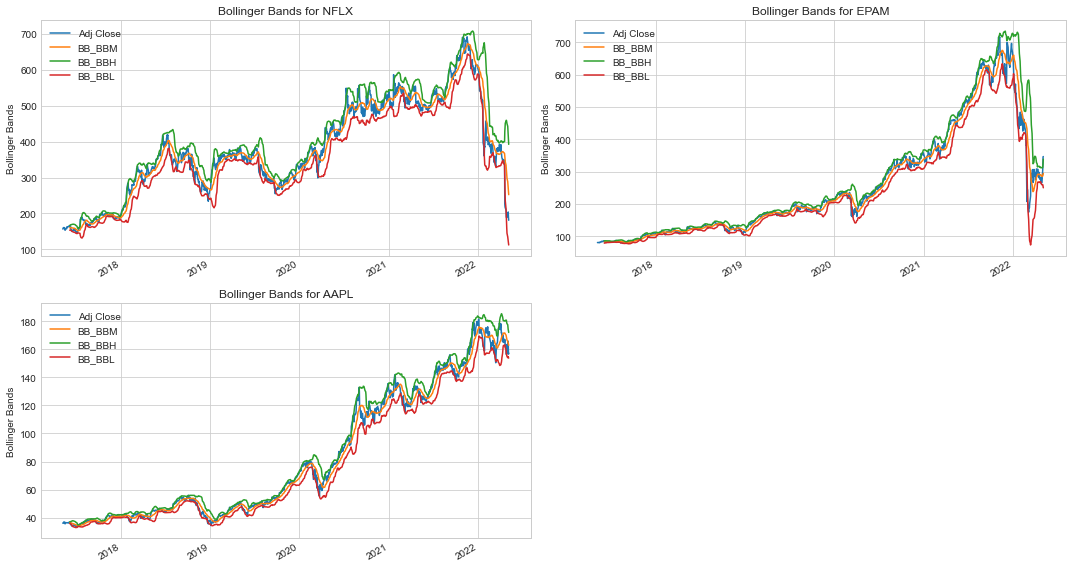

In [1348]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['Adj Close', 'BB_BBM', 'BB_BBH', 'BB_BBL']].plot(ax=ax)
    plt.ylabel('Bollinger Bands')
    plt.xlabel(None)
    plt.title(f"Bollinger Bands for {stock_list[i - 1]}")
    
fig.tight_layout()

### Momentum

In [1349]:
for company in company_list:
    indicator_roc = ROCIndicator(close=company['Adj Close'])
    indicator_rci = RSIIndicator(close=company['Adj Close'])
    indicator_srci = StochRSIIndicator(close=company['Adj Close'])
    company['ROC'] = indicator_roc.roc()
    company['RSI'] = indicator_rci.rsi()
    company['SRSI'] = indicator_srci.stochrsi()

company.tail()

,Open,High,Low,Close,Adj Close,Volume,company_name,MA for 8 days,MA for 21 days,MA for 55 days,...,EMA for 55 days,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BB_BBM,BB_BBH,BB_BBL,ROC,RSI,SRSI
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02,156.710007,158.229996,153.270004,157.960007,157.728256,123055300,Apple,160.228331,166.154920,165.804754,...,165.838044,-2.740870,-1.104273,-1.636597,165.759953,177.518981,154.000925,-7.300463,40.436698,0.350231
2022-05-03,158.149994,160.710007,156.320007,159.479996,159.246017,88966500,Apple,159.362103,165.449766,165.638452,...,165.602614,-2.745405,-0.887047,-1.858359,164.813344,175.412123,154.214564,-3.515038,42.824490,0.495584
2022-05-04,159.669998,166.479996,159.259995,166.020004,165.776428,108256500,Apple,159.890078,164.859205,165.586528,...,165.608822,-2.195962,-0.270082,-1.925879,164.362007,173.940396,154.783619,0.575505,51.781328,1.000000
2022-05-05,163.850006,164.080002,154.949997,156.770004,156.540009,130525300,Apple,159.127449,163.989531,165.295683,...,165.284936,-2.478352,-0.441978,-2.036374,163.610112,173.165583,154.054641,-6.350054,41.805927,0.416577
2022-05-06,156.009995,159.440002,154.179993,157.279999,157.279999,116055700,Apple,159.216204,163.308678,165.022649,...,164.999045,-2.630672,-0.475438,-2.155234,162.879739,172.016721,153.742757,-5.811702,42.757372,0.472223


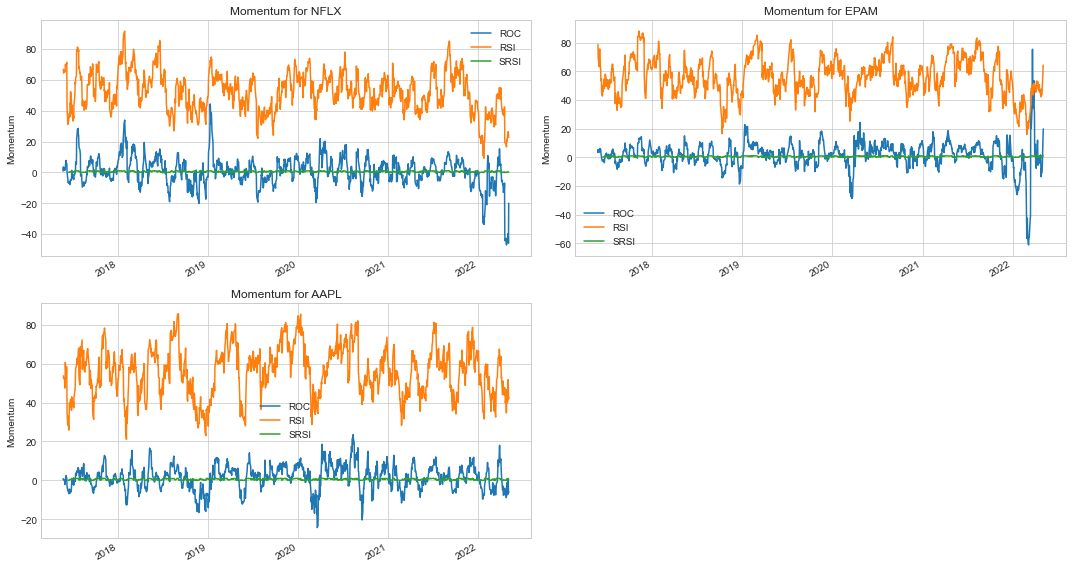

In [1350]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['ROC', 'RSI', 'SRSI']].plot(ax=ax)
    plt.ylabel('Momentum')
    plt.xlabel(None)
    plt.title(f"Momentum for {stock_list[i - 1]}")
    
fig.tight_layout()

### Dayly return

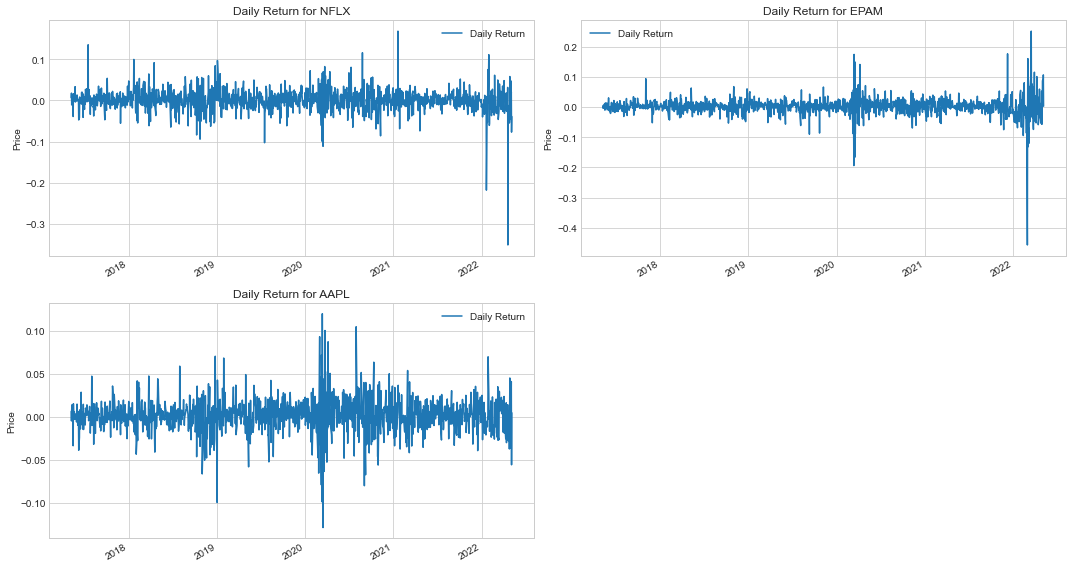

In [1351]:
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()
    company['Open Change'] = company['Open'].pct_change()
    company['High Change'] = company['High'].pct_change()
    company['Low Change'] = company['Low'].pct_change()

    company['Daily Return Log'] = np.log(1 + company['Daily Return'])
    company['Open Change Log'] = np.log(1 + company['Open Change'])
    company['High Change Log'] = np.log(1 + company['High Change'])
    company['Low Change Log'] = np.log(1 + company['Low Change'])

fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['Daily Return']].plot(ax=ax)
    plt.ylabel('Price')
    plt.xlabel(None)
    plt.title(f"Daily Return for {stock_list[i - 1]}")
    
fig.tight_layout()

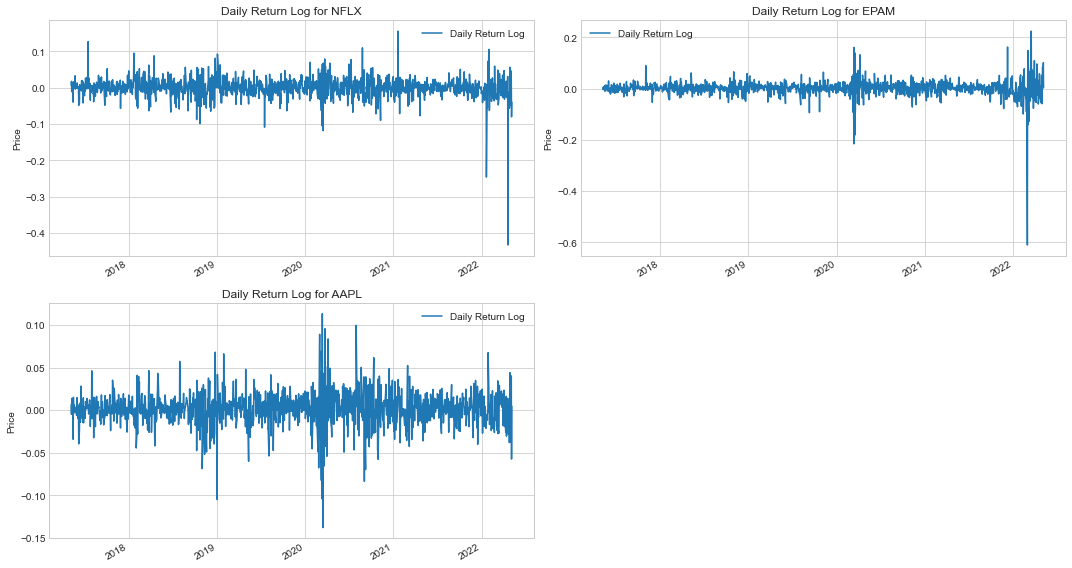

In [1352]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['Daily Return Log']].plot(ax=ax)
    plt.ylabel('Price')
    plt.xlabel(None)
    plt.title(f"Daily Return Log for {stock_list[i - 1]}")
    
fig.tight_layout()

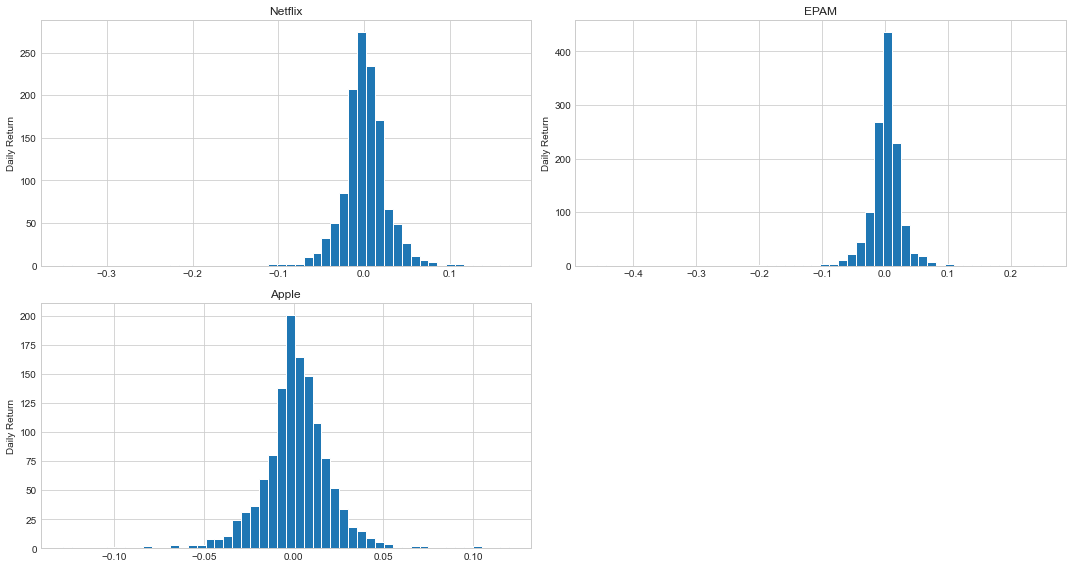

In [1353]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

### Volume change

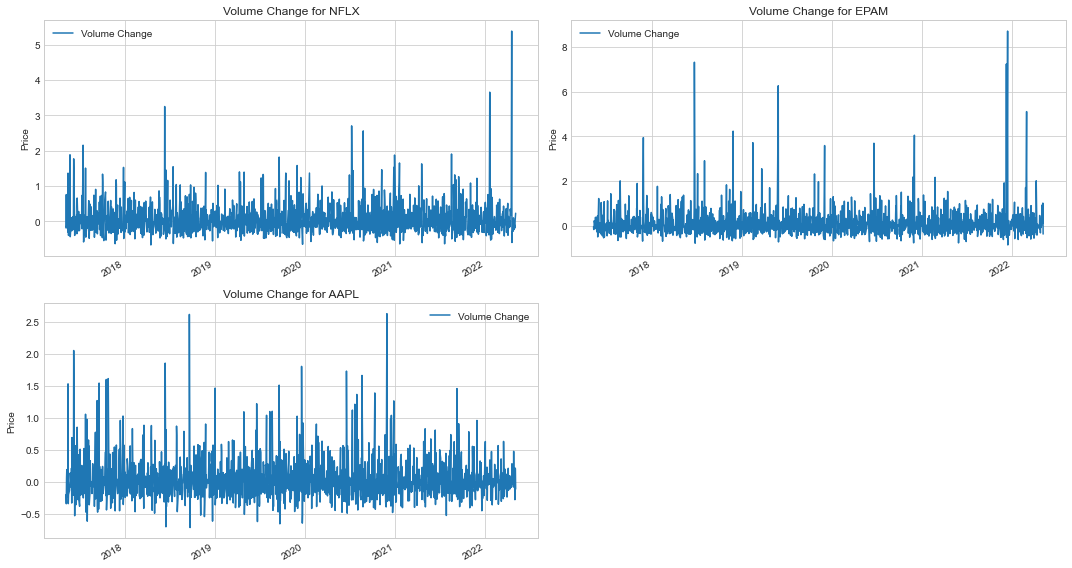

In [1354]:
for company in company_list:
    company['Volume Change'] = company['Volume'].pct_change()

fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    ax = fig.add_subplot(2, 2, i)
    company[['Volume Change']].plot(ax=ax)
    plt.ylabel('Price')
    plt.xlabel(None)
    plt.title(f"Volume Change for {stock_list[i - 1]}")
    
fig.tight_layout()

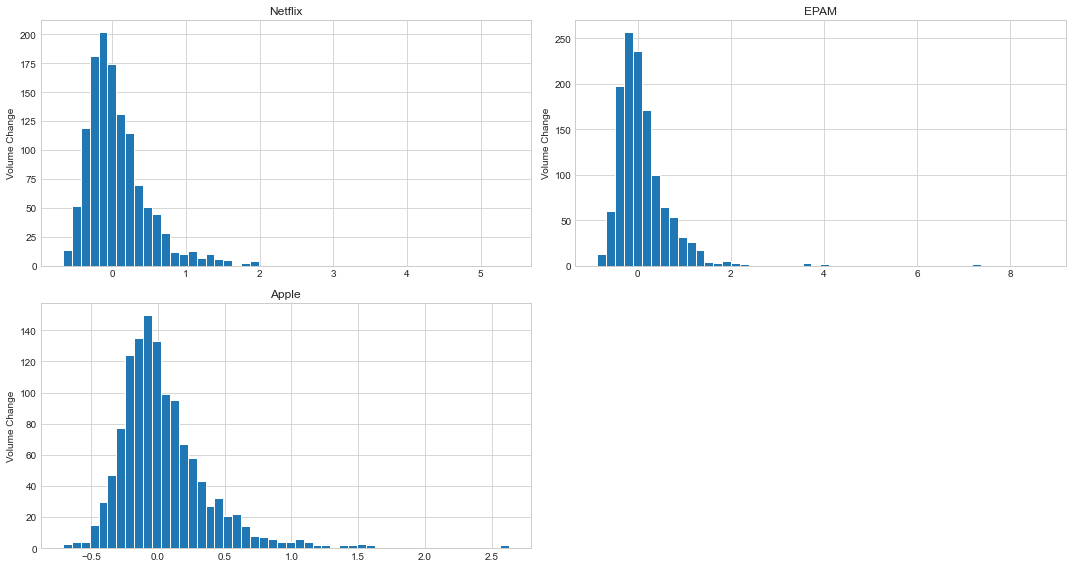

In [1355]:
fig = plt.figure(figsize=(15, 8))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume Change'].hist(bins=50)
    plt.ylabel('Volume Change')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

### Stock correlation

In [1356]:
closing_price = df[['Adj Close', 'company_name']].pivot(columns='company_name', values='Adj Close')
closing_price.head()

company_name,Apple,EPAM,Netflix
Date,,,
2017-05-08,36.063496,80.889999,156.380005
2017-05-09,36.294472,80.610001,157.460007
2017-05-10,36.122414,81.070000,160.279999
2017-05-11,36.434811,80.809998,158.539993
2017-05-12,36.943642,80.610001,160.809998


In [1357]:
returns = closing_price.pct_change()
returns.head()

company_name,Apple,EPAM,Netflix
Date,,,
2017-05-08,NaN,NaN,NaN
2017-05-09,0.006405,-0.003461,0.006906
2017-05-10,-0.004741,0.005706,0.017909
2017-05-11,0.008648,-0.003207,-0.010856
2017-05-12,0.013966,-0.002475,0.014318


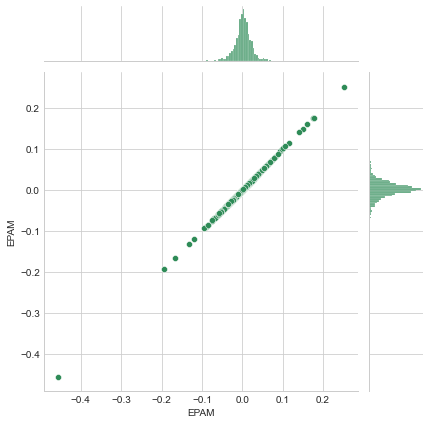

In [1358]:
# Comparing EPAM to itself should show a perfectly linear relationship
sns.jointplot(x='EPAM', y='EPAM', data=returns, kind='scatter', color='seagreen')

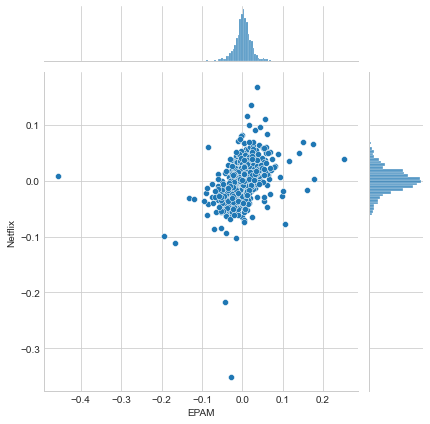

In [1359]:
# Compare the daily returns of stocks
sns.jointplot(x='EPAM', y='Netflix', data=returns, kind='scatter')

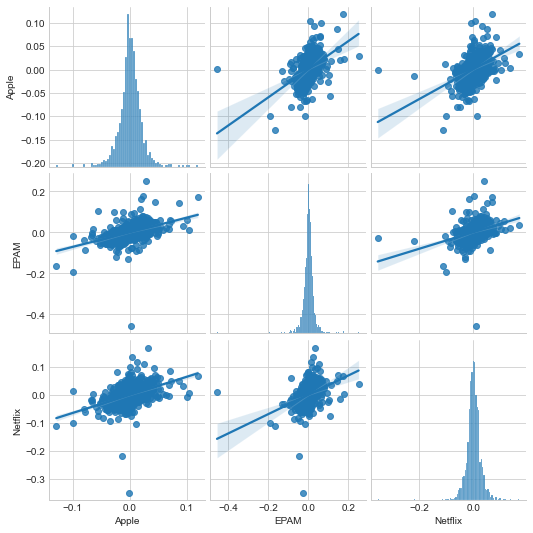

In [1360]:
# Visual analysis of all the stock comparisons
sns.pairplot(returns, kind='reg')

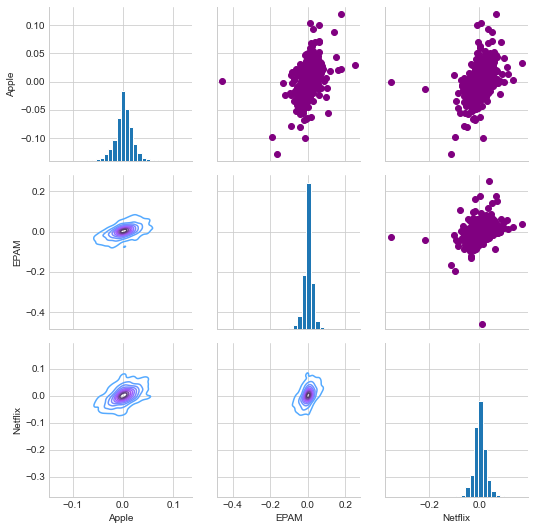

In [1361]:
return_fig = sns.PairGrid(returns.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
return_fig.map_diag(plt.hist, bins=30)

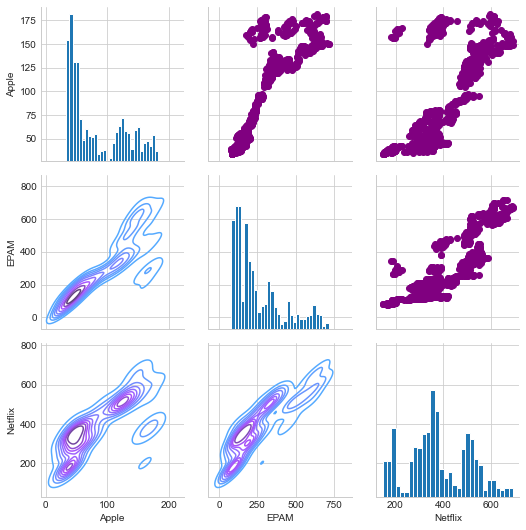

In [1362]:
closing_price_fig = sns.PairGrid(closing_price)
closing_price_fig.map_upper(plt.scatter, color='purple')
closing_price_fig.map_lower(sns.kdeplot, cmap='cool_d')
closing_price_fig.map_diag(plt.hist, bins=30)

<AxesSubplot:xlabel='company_name', ylabel='company_name'>

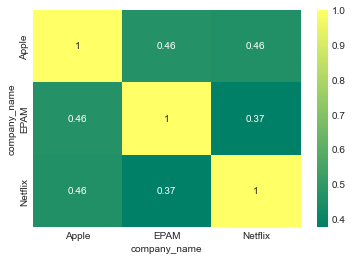

In [1363]:
# Correlation plot for the daily returns
sns.heatmap(returns.corr(), annot=True, cmap='summer')

<AxesSubplot:xlabel='company_name', ylabel='company_name'>

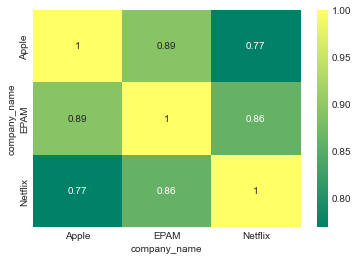

In [1364]:
# Correlation plot for the closing prices
sns.heatmap(closing_price.corr(), annot=True, cmap='summer')

## Build features

### Stock time
In order to get some information from time we have to transform it to format which will be better understand by Transformer network. For this purposes Time2Vector implementation was selected. According to the paper [Time2Vec: Learning a Vector Representation of Time](https://arxiv.org/pdf/1907.05321.pdf) Time2Vector has following benefits which can be used for our case:
 
 - support for periodic and non-periodic patterns;
 - agnocity to time rescaling.

//TODO remove this
1. Proposed architecture
Transformer Layers

 - nn.Transformer A transformer model.
 - nn.TransformerEncoder TransformerEncoder is a stack of N encoder layers
 - nn.TransformerDecoder TransformerDecoder is a stack of N decoder layers
 - nn.TransformerEncoderLayer TransformerEncoderLayer is made up of self-attn and feedforward network.
 - nn.TransformerDecoderLayer TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network.

2. Time2Vec embedding
Sparse Layers

 - nn.Embedding A simple lookup table that stores embeddings of a fixed dictionary and size.
 - nn.EmbeddingBag Computes sums or means of ‘bags’ of embeddings, without instantiating the intermediate embeddings.

Define time to vector embedding module.
//TODO structure added text
### Time 2 Vector Embeddings
Mathematically speaking, implementing Time2Vec is quite easy:

Figure: https://i.ibb.co/yhphBqc/1-E8-Zi-ELOi-Gv-Nu-WCAHX8f-Rw.png

[from https://arxiv.org/pdf/1907.05321.pdf]

Where k is the time2vec dimension, tau is a raw time series, F is a periodic activation function, omega and phi are a set of learnable parameters.

In this notebook, we set F to be a sin function in order to help the algorithm capture periodic behaviors in data. At the same time, the linear term represents the progression of time and can be used for capturing non-periodic patterns in the input that depend on time.

This creates a representation that is somewhat similar to positional embedding while improving its representation power, boosting its performance for time-series data.

Figure: https://i.ibb.co/37h8LvW/1-PYxmooqjij-ARQ2f0-PWAW-g.png



#### TODO build features not completed , normalization required.

In [1365]:
EPAM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-05-08 to 2022-05-06
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1260 non-null   float64
 1   High              1260 non-null   float64
 2   Low               1260 non-null   float64
 3   Close             1260 non-null   float64
 4   Adj Close         1260 non-null   float64
 5   Volume            1260 non-null   int64  
 6   company_name      1260 non-null   object 
 7   MA for 8 days     1253 non-null   float64
 8   MA for 21 days    1240 non-null   float64
 9   MA for 55 days    1206 non-null   float64
 10  EMA for 8 days    1260 non-null   float64
 11  EMA for 21 days   1260 non-null   float64
 12  EMA for 55 days   1260 non-null   float64
 13  MACD_12_26_9      1235 non-null   float64
 14  MACDh_12_26_9     1227 non-null   float64
 15  MACDs_12_26_9     1227 non-null   float64
 16  BB_BBM            1241 n

In [1366]:
EPAM.describe()

,Open,High,Low,Close,Adj Close,Volume,MA for 8 days,MA for 21 days,MA for 55 days,EMA for 8 days,...,SRSI,Daily Return,Open Change,High Change,Low Change,Daily Return Log,Open Change Log,High Change Log,Low Change Log,Volume Change
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03,1253.000000,1240.000000,1206.000000,1260.000000,...,1234.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,254.287309,258.099341,250.208762,254.205262,254.205262,4.123694e+05,254.508411,255.250904,257.340410,253.563394,...,0.540883,0.001654,0.001593,0.001537,0.001581,0.001157,0.001172,0.001190,0.001145,0.125887
std,165.432165,167.745750,162.626010,165.064546,165.064546,5.811790e+05,164.845329,164.514706,163.646872,164.688578,...,0.347469,0.030382,0.028173,0.025935,0.027954,0.032296,0.029507,0.026608,0.030532,0.703039
min,78.379997,79.070000,77.959999,78.830002,78.830002,4.570000e+04,79.691252,80.869049,83.043091,79.695041,...,0.000000,-0.456763,-0.394747,-0.349646,-0.471347,-0.610210,-0.502109,-0.430238,-0.637424,-0.864098
25%,124.660000,125.895000,122.992500,124.312500,124.312500,2.304000e+05,124.460001,124.422501,126.927272,124.103313,...,0.235469,-0.009169,-0.009851,-0.008210,-0.008124,-0.009211,-0.009900,-0.008244,-0.008157,-0.250625
50%,191.025002,194.035004,187.305000,190.845001,190.845001,3.070500e+05,190.682501,190.037382,193.465091,190.107131,...,0.552009,0.002073,0.002640,0.001394,0.002606,0.002071,0.002637,0.001393,0.002602,-0.017852
75%,338.127502,344.277496,332.477493,336.080002,336.080002,4.284500e+05,333.706253,334.891668,338.355364,332.900562,...,0.877986,0.013104,0.013550,0.010849,0.013140,0.013019,0.013459,0.010791,0.013054,0.316353
max,725.400024,725.400024,711.650024,717.489990,717.489990,1.166500e+07,694.121262,674.260481,654.315277,695.895487,...,1.000000,0.251866,0.158280,0.244477,0.164262,0.224636,0.146936,0.218716,0.152087,8.711931


In [1367]:
EPAM.head()

,Open,High,Low,Close,Adj Close,Volume,company_name,MA for 8 days,MA for 21 days,MA for 55 days,...,SRSI,Daily Return,Open Change,High Change,Low Change,Daily Return Log,Open Change Log,High Change Log,Low Change Log,Volume Change
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-08,80.459999,81.010002,79.510002,80.889999,80.889999,378400,EPAM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-09,80.809998,81.639999,80.290001,80.610001,80.610001,359200,EPAM,NaN,NaN,NaN,...,NaN,-0.003461,0.004350,0.007777,0.009810,-0.003467,0.004341,0.007747,0.009762,-0.050740
2017-05-10,80.779999,81.449997,80.550003,81.070000,81.070000,297400,EPAM,NaN,NaN,NaN,...,NaN,0.005706,-0.000371,-0.002327,0.003238,0.005690,-0.000371,-0.002330,0.003233,-0.172049
2017-05-11,81.029999,81.029999,79.820000,80.809998,80.809998,252600,EPAM,NaN,NaN,NaN,...,NaN,-0.003207,0.003095,-0.005157,-0.009063,-0.003212,0.003090,-0.005170,-0.009104,-0.150639
2017-05-12,80.930000,81.000000,79.709999,80.610001,80.610001,308400,EPAM,NaN,NaN,NaN,...,NaN,-0.002475,-0.001234,-0.000370,-0.001378,-0.002478,-0.001235,-0.000370,-0.001379,0.220903


Quick data analisys show that there are several issues in data set:

- some data are missing 
- data not normalized
- company name not categorized

Since 'SRSI' already normalized it will be skipped from normalization.

In [1368]:
EPAM.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'company_name',
       'MA for 8 days', 'MA for 21 days', 'MA for 55 days', 'EMA for 8 days',
       'EMA for 21 days', 'EMA for 55 days', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'BB_BBM', 'BB_BBH', 'BB_BBL', 'ROC', 'RSI', 'SRSI',
       'Daily Return', 'Open Change', 'High Change', 'Low Change',
       'Daily Return Log', 'Open Change Log', 'High Change Log',
       'Low Change Log', 'Volume Change'],
      dtype='object')

In [1369]:
# Remove NaN values
for i, company in enumerate(company_list, 1):   
    company.dropna(how='any', axis=0, inplace=True)    

<AxesSubplot:>

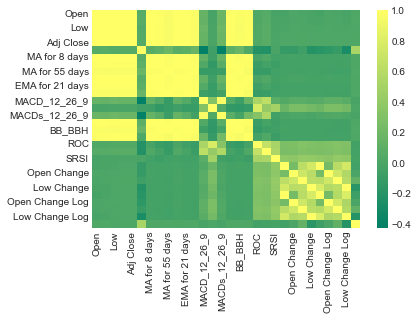

In [1370]:
sns.heatmap(EPAM.corr(), cmap='summer')

<AxesSubplot:>

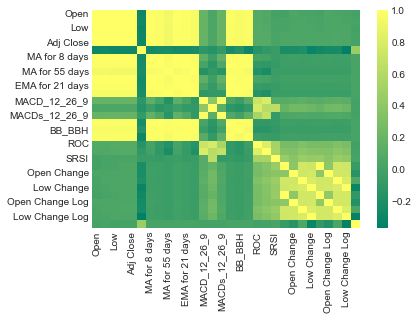

In [1371]:
sns.heatmap(NFLX.corr(), cmap='summer')

<AxesSubplot:>

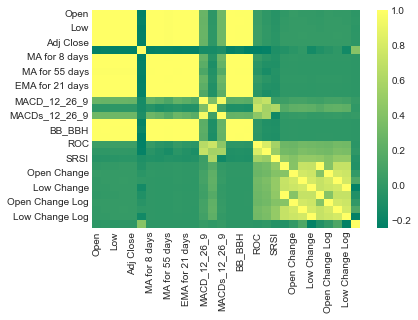

In [1372]:
sns.heatmap(AAPL.corr(), cmap='summer')

In [1482]:
# Split data
splitted_data = {}
test_data_split = 0.1
validation_data_split = 0.1

for i, company in enumerate(company_list, 1):
    stock = stock_list[i - 1]
    print(f"Split {stock} data")

    indexes = sorted(company.index.values)
    # first index of test data
    test_data_index = indexes[-int(test_data_split * len(indexes))]
    # first index of validation data
    validation_data_index = indexes[-int((test_data_split + validation_data_split) * len(indexes))]

    # split data to train, test and validation dataframes
    train_df = company[(company.index < validation_data_index)]
    validation_df = company[np.logical_and(company.index >= validation_data_index, company.index < test_data_index)]
    test_df = company[(company.index >= test_data_index)]
    splitted_data[stock] = {
        "train": train_df,
        "valid": validation_df,
        "test": test_df
    }

splitted_data["EPAM"]['train'].head()


Split NFLX data
Split EPAM data
Split AAPL data


,Open,High,Low,Close,Adj Close,Volume,company_name,MA for 8 days,MA for 21 days,MA for 55 days,...,SRSI,Daily Return,Open Change,High Change,Low Change,Daily Return Log,Open Change Log,High Change Log,Low Change Log,Volume Change
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-25,87.349998,87.870003,86.180000,86.580002,86.580002,159500,EPAM,85.875001,84.429048,83.382727,...,0.730711,-0.008929,-0.000915,-0.000682,-0.011811,-0.008969,-0.000915,-0.000683,-0.011881,0.054894
2017-07-26,86.680000,87.239998,86.080002,86.980003,86.980003,140200,EPAM,86.216251,84.550953,83.493455,...,0.806441,0.004620,-0.007670,-0.007170,-0.001160,0.004609,-0.007700,-0.007196,-0.001161,-0.121003
2017-07-27,87.169998,87.470001,84.540001,85.790001,85.790001,156300,EPAM,86.465001,84.687143,83.587636,...,0.394644,-0.013681,0.005653,0.002636,-0.017890,-0.013776,0.005637,0.002633,-0.018052,0.114836
2017-07-28,85.559998,86.320000,85.459999,85.459999,85.459999,174300,EPAM,86.447501,84.760477,83.667455,...,0.184654,-0.003847,-0.018470,-0.013147,0.010882,-0.003854,-0.018642,-0.013235,0.010824,0.115163
2017-07-31,85.820000,86.370003,84.820000,85.930000,85.930000,300200,EPAM,86.492501,84.872858,83.760545,...,0.300466,0.005500,0.003039,0.000579,-0.007489,0.005485,0.003034,0.000579,-0.007517,0.722318


In [1374]:
def normalize_column(df, column, scaler=None):
    data = df[column].values.reshape(-1, 1)
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(data)
    scaled_data = scaler.transform(data)
    return scaled_data.reshape(1, -1)[0], scaler

In [1483]:
# Normalize data
# Adjusted close prediction configuration
# norm_columns = ['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ROC', 'SRSI', 'RSI', 'Daily Return', 'Volume Change', 'Volume', 'Open Change', 'High Change', 'Low Change',
#     'Daily Return Log', 'Open Change Log', 'High Change Log', 'Low Change Log']
# # "Close" feature removed since it's duplicate of "Adj Close"
# norm_price_columns = ['Open', 'High', 'Low', 'MA for 8 days', 'MA for 21 days', 'MA for 55 days', 'EMA for 8 days',
#        'EMA for 21 days', 'EMA for 55 days', 'BB_BBM', 'BB_BBH', 'BB_BBL']
# norm_target_column = 'Adj Close'

# Daily return configuration
# norm_columns = ['MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ROC', 'SRSI', 'RSI', 'Volume Change', 'Volume', 'Open Change', 'High Change', 'Low Change',
#     'Daily Return Log', 'Open Change Log', 'High Change Log', 'Low Change Log']
# # "Close" feature removed since it's duplicate of "Adj Close"
# norm_price_columns = ['Open', 'High', 'Low', 'Adj Close', 'MA for 8 days', 'MA for 21 days', 'MA for 55 days', 'EMA for 8 days',
#        'EMA for 21 days', 'EMA for 55 days', 'BB_BBM', 'BB_BBH', 'BB_BBL']
# norm_target_column = 'Daily Return'

# Daily return price only with data change
# norm_columns = ['Volume Change']
# norm_price_columns = ['Open Change', 'High Change', 'Low Change']
# norm_target_column = 'Daily Return'

# Use price only without any scaling
norm_columns = []
norm_price_columns = ['Open', 'High', 'Low']
norm_target_column = 'Adj Close'

In [1468]:
target_scalers = {}

for i, stock in enumerate(stock_list):
    stock_data = splitted_data[stock]
    # normalize target values
    train_df = stock_data["train"]
    valid_df = stock_data["valid"]
    test_df = stock_data["test"]

    # create scaler for all price data, to catch releation
    scaler = MinMaxScaler()
    price_values = train_df[norm_price_columns + [norm_target_column]].to_numpy().flatten()

    scaler.fit(price_values.reshape(-1, 1))
    target_scalers[stock] = scaler

    train_scaled_data, _ = normalize_column(train_df, norm_target_column, scaler)
    train_df[norm_target_column] = train_scaled_data

    valid_scaled_data, _ = normalize_column(valid_df, norm_target_column, scaler)
    valid_df[norm_target_column] = valid_scaled_data

    test_scaled_data, _ = normalize_column(test_df, norm_target_column, scaler)
    test_df[norm_target_column] = test_scaled_data

    for data_type in ["train", "valid", "test"]:
        data = stock_data[data_type]
        
        # normalize price columns
        for column in norm_price_columns:
            scaled_data, _ = normalize_column(data, column, scaler)
            data[column] = scaled_data

    # create other columns scalers
    other_scalers = {}
    train_type = "train"
    train_data = stock_data[train_type]

    # normalize other columns
    for column in norm_columns:
        scaled_data, scaler = normalize_column(train_data, column)
        train_data[column] = scaled_data
        other_scalers[column] = scaler
    
    for data_type in ["valid", "test"]:
        data = stock_data[data_type]
        
        for column in norm_columns:
            scaled_data, _ = normalize_column(data, column, other_scalers[column])
            data[column] = scaled_data

splitted_data["EPAM"]['train'].describe()

/var/folders/sh/ghxrfz3946z44kkqlbdt4l8j61y3q1/T/ipykernel_21073/757784378.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[norm_target_column] = train_scaled_data
/var/folders/sh/ghxrfz3946z44kkqlbdt4l8j61y3q1/T/ipykernel_21073/757784378.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df[norm_target_column] = valid_scaled_data
/var/folders/sh/ghxrfz3946z44kkqlbdt4l8j61y3q1/T/ipykernel_21073/757784378.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Open,High,Low,Close,Adj Close,Volume,MA for 8 days,MA for 21 days,MA for 55 days,EMA for 8 days,...,SRSI,Daily Return,Open Change,High Change,Low Change,Daily Return Log,Open Change Log,High Change Log,Low Change Log,Volume Change
count,965.000000,965.000000,965.000000,965.000000,965.000000,9.650000e+02,965.000000,965.000000,965.000000,965.000000,...,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000
mean,199.068881,201.824767,196.319523,199.298612,199.298612,3.436437e+05,197.914144,195.417151,189.232685,197.921581,...,0.547495,0.531353,0.531144,0.531059,0.531187,0.001775,0.001765,0.001771,0.001762,0.111993
std,96.083612,97.478802,94.719198,96.299193,96.299193,2.198420e+05,95.006858,92.842977,87.579768,94.967721,...,0.345565,0.064602,0.056728,0.051579,0.058711,0.023929,0.020906,0.018984,0.021851,0.080797
min,78.379997,79.070000,77.959999,78.830002,78.830002,4.570000e+04,79.691252,80.869049,83.043091,79.695041,...,0.000000,0.000000,0.212944,0.182716,0.043399,-0.215330,-0.122464,-0.135133,-0.195691,0.000000
25%,122.989998,124.500000,121.589996,123.019997,123.019997,2.270000e+05,122.496251,122.413334,121.400364,122.946222,...,0.246898,0.504327,0.501067,0.504700,0.505739,-0.007928,-0.009139,-0.007790,-0.007404,0.065427
50%,175.479996,177.940002,172.869995,175.080002,175.080002,3.002000e+05,174.856253,173.971906,172.339999,175.060315,...,0.552741,0.531588,0.532924,0.529845,0.534332,0.002146,0.002637,0.001505,0.003154,0.093797
75%,237.179993,240.770004,233.429993,237.979996,237.979996,4.089000e+05,234.311251,232.367144,223.627636,234.072447,...,0.889246,0.560404,0.561944,0.555066,0.561567,0.012685,0.013245,0.010741,0.013108,0.136527
max,480.000000,485.910004,477.450012,484.420013,484.420013,3.946200e+06,459.726254,458.341906,421.973091,465.538282,...,1.000000,1.000000,0.897896,0.814937,0.779805,0.161049,0.128500,0.101250,0.089483,1.000000


In [1376]:
def draw_feature_split(column):
    fig = plt.figure(figsize=(15,12))
    st = fig.suptitle("Data Separation", fontsize=20)
    st.set_y(0.95)
    
    for i, stock in enumerate(stock_list, 1):
        stock_data = splitted_data[stock]
        # normalize target values
        train_df = stock_data["train"]
        valid_df = stock_data["valid"]
        test_df = stock_data["test"]

        ax1 = fig.add_subplot(210 + i)
        ax1.plot(np.arange(train_df.values.shape[0]), train_df[column], label='Training data')

        ax1.plot(np.arange(train_df.values.shape[0], train_df.values.shape[0] + valid_df.values.shape[0]), valid_df[column], label='Validation data')

        ax1.plot(np.arange(
            train_df.values.shape[0] + valid_df.values.shape[0], train_df.values.shape[0] + valid_df.values.shape[0] + test_df.values.shape[0]
        ), test_df[column], label='Test data')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Normalized ' + column)
        ax1.set_title(column, fontsize=18)
        ax1.legend(loc="best", fontsize=12) 

ValueError: num must be 1 <= num <= 2, not 3

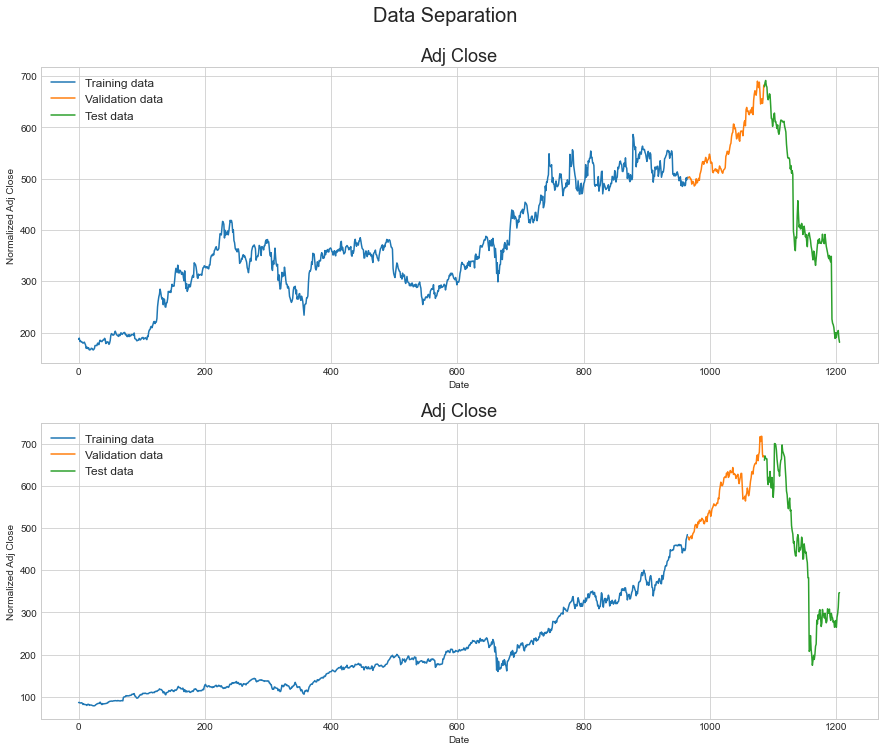

In [1484]:
draw_feature_split("Adj Close")

ValueError: num must be 1 <= num <= 2, not 3

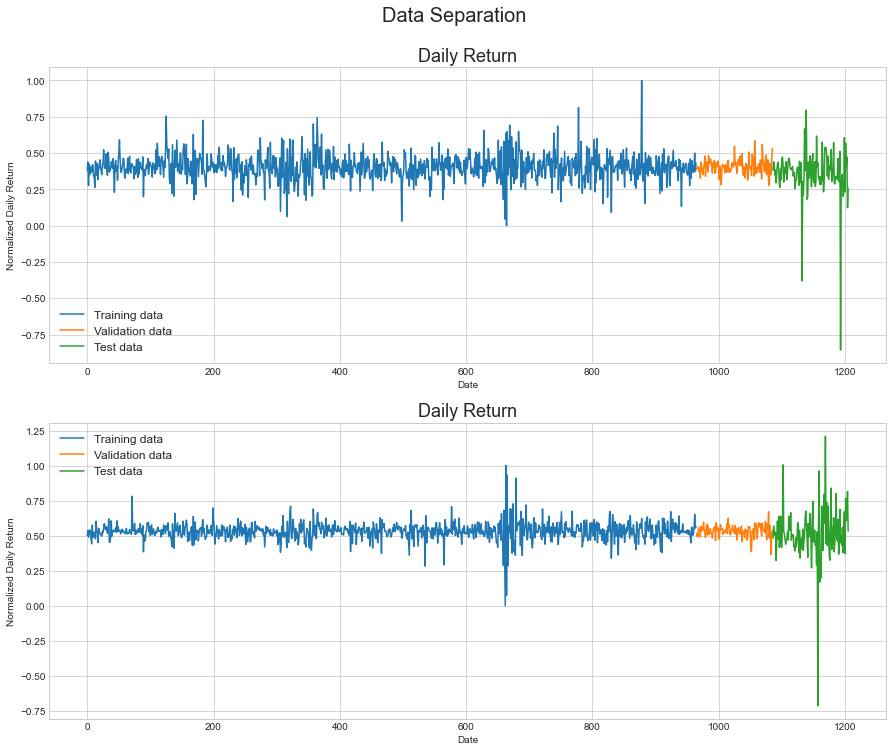

In [1401]:
draw_feature_split("Daily Return")

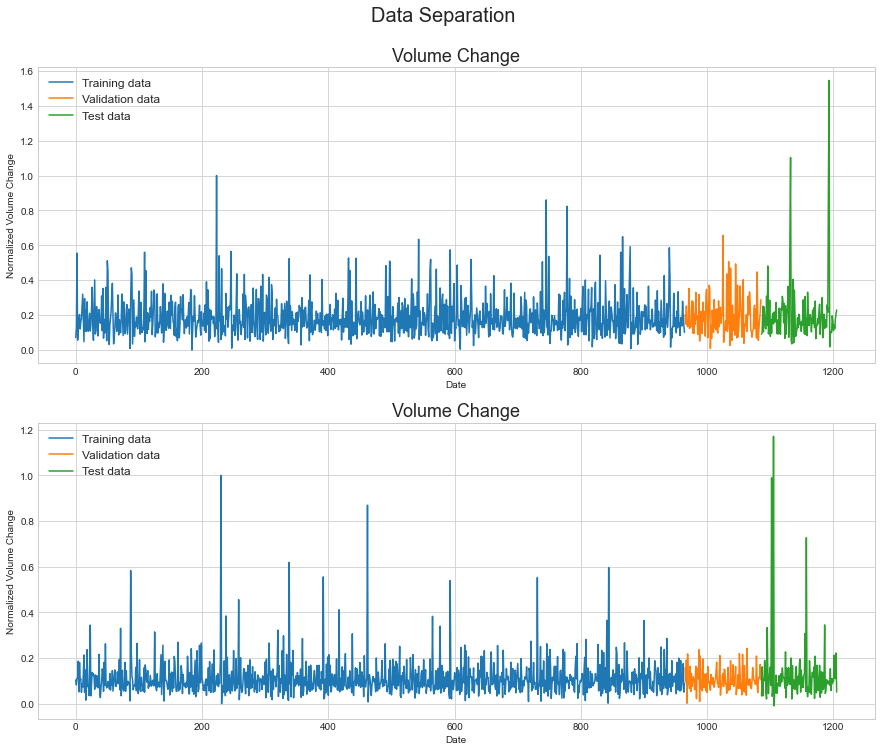

In [982]:
draw_feature_split("Volume Change")

In [1379]:
# split data to sequences of defined lenght
def split_to_sequences(feature_data, target_data, seq_len):
  X_train, y_train = [], []
  if len(feature_data) != len(target_data):
    raise Exception("Feature and target length should match.")
  
  for i in range(seq_len, len(feature_data)):
    x_train_seq = feature_data[i-seq_len:i]
    X_train.append(x_train_seq)

    y_train_seq = target_data[i]
    y_train.append(y_train_seq)
  
  return np.array(X_train), np.array(y_train)

In [1485]:
# create datasets and data loaders
dataloaders = {}
batch_size = 64
seq_len = 64

feature_columns = norm_price_columns + norm_columns
target_column = norm_target_column

for i, stock in enumerate(stock_list):
    stock_data = splitted_data[stock]
    
    # normalize target values
    train_df = stock_data["train"]
    valid_df = stock_data["valid"]
    test_df = stock_data["test"]

    # create dataloaders
    X_train, y_train = split_to_sequences(
        train_df[feature_columns].values,
        train_df[target_column].values,
        seq_len
    )
    print(f"Test data for {stock} features shape: {X_train.shape}, target shape: {y_train.shape}")
    train_tensor = torch.tensor(X_train).float()
    train_tensor_target = torch.tensor(y_train).float()
    train_dataset = TensorDataset(train_tensor, train_tensor_target)

    X_valid, y_valid = split_to_sequences(
        valid_df[feature_columns].values,
        valid_df[target_column].values,
        seq_len
    )
    print(f"Test data for {stock} features shape: {X_valid.shape}, target shape: {y_valid.shape}")
    valid_tensor = torch.tensor(X_valid).float()
    valid_tensor_traget = torch.tensor(y_valid).float()
    valid_dataset = TensorDataset(valid_tensor, valid_tensor_traget)

    X_test, y_test = split_to_sequences(
        test_df[feature_columns].values,
        test_df[target_column].values,
        seq_len
    )
    print(f"Test data for {stock} features shape: {X_test.shape}, target shape: {y_test.shape}")
    test_tensor = torch.tensor(X_test).float()
    test_tensor_target = torch.tensor(y_test).float()
    test_dataset = TensorDataset(test_tensor, test_tensor_target)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    dataloaders[stock] = {
        "train": train_loader,
        "valid": valid_loader,
        "test": test_loader
    }

Test data for NFLX features shape: (901, 64, 3), target shape: (901,)
Test data for NFLX features shape: (57, 64, 3), target shape: (57,)
Test data for NFLX features shape: (56, 64, 3), target shape: (56,)
Test data for EPAM features shape: (901, 64, 3), target shape: (901,)
Test data for EPAM features shape: (57, 64, 3), target shape: (57,)
Test data for EPAM features shape: (56, 64, 3), target shape: (56,)
Test data for AAPL features shape: (901, 64, 3), target shape: (901,)
Test data for AAPL features shape: (57, 64, 3), target shape: (57,)
Test data for AAPL features shape: (56, 64, 3), target shape: (56,)


### Transformer architecture

In [1129]:
class Time2Vector(nn.Module):
    
    def __init__(self, sequnce_size: int = 1, feature_num: int = 1):
        """
        Apply time to vector embedding.

        Args:
            sequnce_size: size of event sequence in time
            feature_num: number of features in sequence
        """
        super(Time2Vector, self).__init__()
        
        self.sequnce_size = sequnce_size
        self.feature_num = feature_num
        self.weights_linear = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_linear = torch.nn.Parameter(torch.empty(feature_num))
        self.weights_periodic = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_periodic = torch.nn.Parameter(torch.empty(feature_num))
        self.func_periodic = torch.sin
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Initialize component weights
        """
        # init linear weights
        nn.init.uniform_(self.weights_linear, -1, 1)
        nn.init.uniform_(self.bias_linear, -1, 1)
        
        # init periodic weights
        nn.init.uniform_(self.weights_periodic, -1, 1)
        nn.init.uniform_(self.bias_periodic, -1, 1)

    def forward(self, x):
        weights_linear = self.weights_linear.expand(x.shape[0], self.sequnce_size, self.feature_num)
        linear = torch.mul(weights_linear, x) + self.bias_linear
        weights_periodic = self.weights_periodic.expand(x.shape[0], self.sequnce_size, self.feature_num)
        periodic = self.func_periodic(torch.mul(weights_periodic, x) + self.bias_periodic)
        return torch.cat([linear, periodic], 2)

In [1403]:
sequence_lenght = 64
feature_num = 5
batch_size = 64
t2v = Time2Vector(sequence_lenght, feature_num)
input = torch.rand(batch_size, sequence_lenght, feature_num)
print(f"Input shape: {input.shape}")
time_features = t2v(input)
print(f"Time feature shape: {time_features.shape}")

# concatinate time feature vector to original vector
input = torch.cat([input, time_features], 2)
print(f"Output shape: {input.shape}")

Input shape: torch.Size([64, 64, 5])
Time feature shape: torch.Size([64, 64, 10])
Output shape: torch.Size([64, 64, 15])


In [1249]:
class Model(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=3, dropout=0.2):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(Model, self).__init__()

        # number of features should be divisible by num_heads
        # num_heads=num_features
        self.time_embedding = Time2Vector(sequence_lenght, num_features)
        encoder_features = num_features + num_features * 2
        num_heads=encoder_features
        layer = nn.TransformerEncoderLayer(d_model=encoder_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        # nn.AvgPool1d kernel_size equal to the dimensions of the feature maps.
        # self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers, norm=nn.AvgPool1d(encoder_features))
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.avg_poll = nn.AvgPool1d(encoder_features) # average
        # self.avg_poll = nn.AdaptiveAvgPool1d(1) # adaptive
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(sequence_lenght, 128)
        self.dropout1 = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(128, 1)


    def forward(self, input):
        # print(f"Raw input shape: {input.shape}")
        x = self.time_embedding(input)
        # print(f"Embeddings shape: {x.shape}")
        x = torch.cat([input, x], 2)
        # print(f"Input data with time features shape: {x.shape}")
        x = self.encoder(x)
        # print(f"Encoder output shape: {x.shape}")
        # print(f"Encoder output shape: {x[:5]}")
        x = self.avg_poll(x) # ??? do we really need this pooling
        # print(f"Avg pool output shape: {x.shape}")
        # print(f"Avg pool output: {x}")
        x = torch.squeeze(x, dim=2) # reduce dimentions
        # print(f"Avg1 pool output shape: {x.shape}")
        # print(f"Avg1 pool output: {x}")
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        # print(f"Linear output shape: {x.shape}")
        x = self.dropout1(x)
        x = self.linear1(x)
        # print(f"Linear1 output shape: {x.shape}")
        return x

In [1161]:
sequence_lenght = 32
feature_num = 22
batch_size = 64
# number of features should be divisible by num_heads
test_model = Model(sequence_lenght, feature_num)
input = torch.rand(batch_size, sequence_lenght, feature_num)
print(f"Input shape: {input.shape}")
output = test_model(input)
print(f"Output shape: {output.shape}")

Input shape: torch.Size([64, 32, 22])
Output shape: torch.Size([64, 1])


In [1436]:
class ModelConv(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=3, dropout=0.2):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(ModelConv, self).__init__()

        # number of features should be divisible by num_heads
        # num_heads=num_features
        self.time_embedding = Time2Vector(sequence_lenght, num_features)
        encoder_features = num_features + num_features * 2
        num_heads = encoder_features
        layer = nn.TransformerEncoderLayer(d_model=encoder_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        # nn.AvgPool1d kernel_size equal to the dimensions of the feature maps.
        # self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers, norm=nn.AvgPool1d(encoder_features))
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.linear = nn.Linear(encoder_features, 128)
        self.dropout = nn.Dropout(p=dropout)
        self.avg_poll = nn.AvgPool1d(2)
        # self.avg_poll = nn.AdaptiveAvgPool1d(1) # adaptive
        self.linear1 = nn.Linear(64, 32)
        self.dropout1 = nn.Dropout(p=dropout)
        self.avg_poll1 = nn.AvgPool1d(32)
        self.linear2 = nn.Linear(64, 1)
        self.dropout2 = nn.Dropout(p=dropout)


    def forward(self, input):
        # print(f"Raw input shape: {input.shape}")
        x = self.time_embedding(input)
        # print(f"Embeddings shape: {x.shape}")
        x = torch.cat([input, x], 2)
        # print(f"Input data with time features shape: {x.shape}")
        x = self.encoder(x)
        x = self.dropout(x)
        # print(f"Shape enc: {x.shape}")
        x = F.leaky_relu(self.linear(x))
        # print(f"Shape L: {x.shape}")
        x = self.avg_poll(x)
        # print(f"Shape L avg: {x.shape}")
        x = self.dropout1(x)
        x = F.leaky_relu(self.linear1(x))
        # print(f"Shape L1: {x.shape}")
        x = self.avg_poll1(x)
        # print(f"Shape L1 avg: {x.shape}")
        x = torch.squeeze(x, dim=2)
        # print(f"Shape sqz: {x.shape}")
        x = self.dropout2(x)
        x = self.linear2(x)
        # x = torch.squeeze(x, dim=2)
        return x

In [1470]:
sequence_lenght = 64
feature_num = 4
batch_size = 64
# number of features should be divisible by num_heads
test_model = ModelConv(sequence_lenght, feature_num)
input = torch.rand(batch_size, sequence_lenght, feature_num)
print(f"Input shape: {input.shape}")
output = test_model(input)
print(f"Output shape: {output.shape}")

Input shape: torch.Size([64, 64, 4])
Output shape: torch.Size([64, 1])


In [1435]:
test_model

ModelConv(
  (time_embedding): Time2Vector()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=66, out_features=66, bias=True)
        )
        (linear1): Linear(in_features=66, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=66, bias=True)
        (norm1): LayerNorm((66,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((66,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=66, out_features=66, bias=True)
        )
        (linear1): Linear(in_features=66, out_features=2048, bias=True)
        (drop

### Train model

In [1081]:
# train model
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader, 1):
        # Compute prediction error
        pred = model(X)
        pred = torch.squeeze(pred, dim=1)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return train_loss

In [1082]:
# test model
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred = torch.squeeze(pred, dim=1)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
    test_loss /= num_batches
    print(f"\nTest loss: {test_loss:>8f}")
    return test_loss

In [1486]:
# ConvModel parameters
# lr=0.001 no dropout
# lr=0.001 dropout e=50 (30) 0.03
# lr=0.0001 dropout e=50 (30) 0.009
# lr=0.0001 no dropout

epochs = 30
sequence_lenght = seq_len
feature_num = len(feature_columns)

model = ModelConv(sequence_lenght, feature_num)
# model = Model(sequence_lenght, feature_num)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# stock = "NFLX"
stock = "AAPL"
# stock = "EPAM"

train_loader = dataloaders[stock]["train"]
valid_loader = dataloaders[stock]["valid"]
test_loader = dataloaders[stock]["test"]

train_losses = []
valid_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer)
    valid_loss = test(valid_loader, model, loss_fn)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch 1
-------------------------------
Train loss: 6425.798120

Test loss: 21654.958984
Epoch 2
-------------------------------
Train loss: 6423.177181

Test loss: 21652.806641
Epoch 3
-------------------------------
Train loss: 6421.751668

Test loss: 21651.683594
Epoch 4
-------------------------------
Train loss: 6420.907902

Test loss: 21650.818359
Epoch 5
-------------------------------
Train loss: 6420.335360

Test loss: 21650.367188
Epoch 6
-------------------------------
Train loss: 6419.783057

Test loss: 21649.908203
Epoch 7
-------------------------------
Train loss: 6419.229346

Test loss: 21649.470703
Epoch 8
-------------------------------
Train loss: 6418.986938

Test loss: 21649.056641
Epoch 9
-------------------------------
Train loss: 6418.646785

Test loss: 21648.640625
Epoch 10
-------------------------------
Train loss: 6418.274528

Test loss: 21648.232422
Epoch 11
-------------------------------
Train loss: 6417.997217

Test loss: 21647.820312
Epoch 12
----------

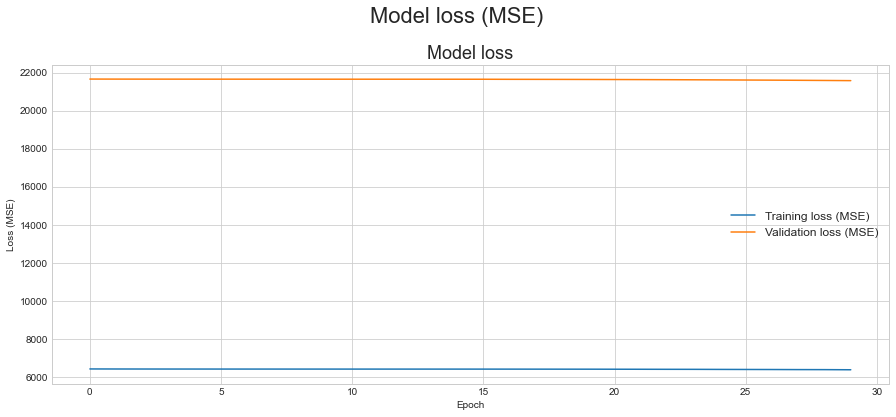

In [1487]:
# plot training and test losses.
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Model loss (MSE)", fontsize=22)
st.set_y(0.92)

ax1 = fig.add_subplot(311)
ax1.plot(train_losses[0:], label='Training loss (MSE)')
ax1.plot(valid_losses[0:], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

In [1237]:
# Check for outliers in features, bcs it might lead to averaging of data.
# Check how features constructed, percentege of change of absolut normalize values.

# test model
model.eval()
predictions = np.array([])
original = np.array([])
with torch.no_grad():
    for X, y in train_loader:
        # print(X.shape)
        # print(X)
        pred = model(X)
        pred = torch.squeeze(pred, dim=1)
        loss = loss_fn(pred, y)
        predictions = np.append(predictions, pred.numpy())
        original = np.append(original, y.numpy())
        print(loss.item())
        print(pred.shape)
        print(y.shape)


0.004568576347082853
torch.Size([64])
torch.Size([64])
0.004390684422105551
torch.Size([64])
torch.Size([64])
0.004702666774392128
torch.Size([64])
torch.Size([64])
0.005896649323403835
torch.Size([64])
torch.Size([64])
0.007183734327554703
torch.Size([64])
torch.Size([64])
0.0051544890739023685
torch.Size([64])
torch.Size([64])
0.005675002932548523
torch.Size([64])
torch.Size([64])
0.0058342390693724155
torch.Size([64])
torch.Size([64])
0.009145310148596764
torch.Size([64])
torch.Size([64])
0.02011570706963539
torch.Size([64])
torch.Size([64])
0.013810943812131882
torch.Size([64])
torch.Size([64])
0.017759572714567184
torch.Size([64])
torch.Size([64])
0.015593061223626137
torch.Size([64])
torch.Size([64])
0.006960161030292511
torch.Size([64])
torch.Size([64])
0.004235826898366213
torch.Size([37])
torch.Size([37])


In [1488]:
model.eval()
predictions = np.array([])
original = np.array([])
with torch.no_grad():
    for loader in [train_loader, valid_loader, test_loader]:
        for X, y in loader:
            # print(X.shape)
            # print(X)
            pred = model(X)
            pred = torch.squeeze(pred, dim=1)
            loss = loss_fn(pred, y)
            predictions = np.append(predictions, pred.numpy())
            original = np.append(original, y.numpy())

In [1450]:
def draw_prediction(original, predictions):
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Transformer predictions", fontsize=22)
    st.set_y(0.92)

    ax11 = fig.add_subplot(311)
    ax11.plot(original, label='Original')
    ax11.plot(predictions, linewidth=3, label='Predicted')
    ax11.set_title("Training Data", fontsize=18)
    ax11.set_xlabel('Date')
    ax11.set_ylabel('Close price')
    ax11.legend(loc="best", fontsize=12)



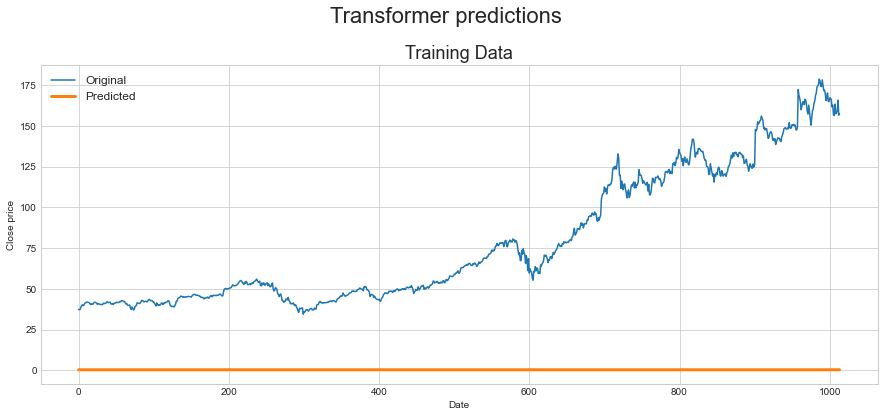

In [1489]:
draw_prediction(original, predictions)

### Split data
Data will be splited to following datasets:

- train
- validation
- test

In [993]:
# dataloaders = {}
# batch_size = 54
# for i, company in enumerate(company_list, 1):   
#     times = sorted(company.index.values)
#     train_test_split(X, y, test_size=0.33, shuffle=False)



    # train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
    # validation_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    # test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # dataloaders[company] = {
    #     "train": train_dataloader,
    #     "validation": validation_dataloader,
    #     "test": test_dataloader
    # }

# Experimetnts
// TODO remove it later

In [1214]:
a = np.array([1, 2])
b = np.array([5, 6])
print(np.append(a, b))

[1 2 5 6]


In [1152]:
t = torch.rand(2, 3, 4)
print(t)
pool = nn.AvgPool1d(2)
t = pool(t)
print(t)
print(t.shape)

tensor([[[0.2156, 0.9299, 0.4332, 0.3210],
         [0.1153, 0.5797, 0.4417, 0.5157],
         [0.1051, 0.5917, 0.4639, 0.8716]],

        [[0.4780, 0.5606, 0.0105, 0.8364],
         [0.6424, 0.0109, 0.7046, 0.8347],
         [0.8987, 0.0160, 0.3994, 0.3199]]])
tensor([[[0.5727, 0.3771],
         [0.3475, 0.4787],
         [0.3484, 0.6677]],

        [[0.5193, 0.4234],
         [0.3267, 0.7696],
         [0.4573, 0.3597]]])
torch.Size([2, 3, 2])


In [1154]:
t = torch.rand(2, 3, 4)
print(t)
pool = nn.AdaptiveAvgPool1d(5)
t = pool(t)
print(t)
print(t.shape)

tensor([[[0.1353, 0.6214, 0.0306, 0.1936],
         [0.1149, 0.4618, 0.5732, 0.9754],
         [0.0102, 0.5108, 0.4796, 0.2903]],

        [[0.4211, 0.5362, 0.1346, 0.6146],
         [0.0626, 0.8839, 0.3992, 0.8026],
         [0.9856, 0.0280, 0.1852, 0.7214]]])
tensor([[[0.1353, 0.3783, 0.3260, 0.1121, 0.1936],
         [0.1149, 0.2884, 0.5175, 0.7743, 0.9754],
         [0.0102, 0.2605, 0.4952, 0.3849, 0.2903]],

        [[0.4211, 0.4787, 0.3354, 0.3746, 0.6146],
         [0.0626, 0.4732, 0.6416, 0.6009, 0.8026],
         [0.9856, 0.5068, 0.1066, 0.4533, 0.7214]]])
torch.Size([2, 3, 5])


In [995]:
t = torch.rand(2, 3, 1)
print(t)
print(torch.squeeze(t, dim=2))
t1 = torch.rand(2, 3)
print(t1)

tensor([[[0.8484],
         [0.7694],
         [0.1058]],

        [[0.3895],
         [0.4876],
         [0.8210]]])
tensor([[0.8484, 0.7694, 0.1058],
        [0.3895, 0.4876, 0.8210]])
tensor([[0.1273, 0.9409, 0.5177],
        [0.6430, 0.1555, 0.4706]])


In [996]:
features = 6
pool = nn.AvgPool1d(features)

tensor = torch.randn(1, 2, 6)
print(tensor)
print(tensor.shape)
y = pool(tensor)
print(y)
print(y.shape)

tensor([[[-0.9774, -1.0889,  0.4188,  1.4875, -1.0863,  0.5363],
         [-1.4886, -0.0702, -0.6462, -0.0162, -1.2135,  1.1218]]])
torch.Size([1, 2, 6])
tensor([[[-0.1183],
         [-0.3855]]])
torch.Size([1, 2, 1])


In [997]:
data = [1, 3, 4]
data = data + [5]
data

[1, 3, 4, 5]

In [998]:
arr = np.array([11, 2, 6, 7, 2])
arr = np.append(arr, 44)
print(arr)

[11  2  6  7  2 44]


In [999]:
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 11])
data = data.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data).reshape(1, -1)[0]
print(scaled_data)
print(scaler.data_max_)
print(scaler.data_min_)

data_small = np.array([5, 6])
data_small = data_small.reshape(-1, 1)
scaled_small_data = scaler.transform(data_small).reshape(1, -1)[0]
print(scaled_small_data)

data = np.array([0.1, 0.2, 1, 1.1, 1.2, 2]).reshape(-1, 1)
inverse_scale = scaler.inverse_transform(data).reshape(1, -1)[0]
print(inverse_scale)
inverse_scale = scaler.inverse_transform(data).flatten()
print(inverse_scale)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 1. ]
[11.]
[1.]
[0.4 0.5]
[ 2.  3. 11. 12. 13. 21.]
[ 2.  3. 11. 12. 13. 21.]


In [1000]:
# df slice
data = [{'a': 1, 'b': 2, 'c':3, 'd':4, 'e':5},
        {'a':11, 'b': 21, 'c': 31, 'd':41, 'e':51},
        {'a':12, 'b': 22, 'c': 32, 'd':42, 'e':52},
        {'a':13, 'b': 23, 'c': 33, 'd':43, 'e':53},
        {'a':14, 'b': 24, 'c': 34, 'd':44, 'e':54}]
 
# Creates DataFrame.
df = pd.DataFrame(data)
print(df.head())

i = 3
# all row 3-rd index column and first element
print(df.values[:, 3][i])

seq_len = 3
print(df.values[i-seq_len:i])

# 1 - row and second column
dd = df.values[2:4]
print(dd)
print(dd.shape)


    a   b   c   d   e
0   1   2   3   4   5
1  11  21  31  41  51
2  12  22  32  42  52
3  13  23  33  43  53
4  14  24  34  44  54
43
[[ 1  2  3  4  5]
 [11 21 31 41 51]
 [12 22 32 42 52]]
[[12 22 32 42 52]
 [13 23 33 43 53]]
(2, 5)


In [1001]:
data = [{'a': 1, 'b': 2, 'c':3, 'd':4, 'e':5},
        {'a':11, 'b': 21, 'c': 31, 'd':41, 'e':51},
        {'a':12, 'b': 22, 'c': 32, 'd':42, 'e':52},
        {'a':13, 'b': 23, 'c': 33, 'd':43, 'e':53},
        {'a':14, 'b': 24, 'c': 34, 'd':44, 'e':54}]
 
# Creates DataFrame.
df = pd.DataFrame(data)
print(df.head())

seq_len = 3
train_data = df[['a', 'b', 'c', 'd', 'e']].values
target_data = df['d'].values
print(target_data)
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  x_train_part = train_data[i-seq_len:i]
  print(f"X train: {x_train_part}")
  X_train.append(x_train_part) # Chunks of training data with a length of 128 df-rows

  y_train_part = target_data[i]
  print(f"Y train: {y_train_part}")
  y_train.append(y_train_part) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)



    a   b   c   d   e
0   1   2   3   4   5
1  11  21  31  41  51
2  12  22  32  42  52
3  13  23  33  43  53
4  14  24  34  44  54
[ 4 41 42 43 44]
X train: [[ 1  2  3  4  5]
 [11 21 31 41 51]
 [12 22 32 42 52]]
Y train: 43
X train: [[11 21 31 41 51]
 [12 22 32 42 52]
 [13 23 33 43 53]]
Y train: 44
[[[ 1  2  3  4  5]
  [11 21 31 41 51]
  [12 22 32 42 52]]

 [[11 21 31 41 51]
  [12 22 32 42 52]
  [13 23 33 43 53]]]
(2, 3, 5)
[43 44]
(2,)


In [1002]:
data = [{'a': 1, 'b': 2, 'c':3, 'd':4, 'e':5},
        {'a':11, 'b': 21, 'c': 31, 'd':41, 'e':51},
        {'a':12, 'b': 22, 'c': 32, 'd':42, 'e':52},
        {'a':13, 'b': 23, 'c': 33, 'd':43, 'e':53},
        {'a':14, 'b': 24, 'c': 34, 'd':44, 'e':54}]
 
# Creates DataFrame.
df = pd.DataFrame(data)
print(df.head())

seq_len = 3
train_data = df.values
print(f"Train data: {train_data}")

X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  x_train_part = train_data[i-seq_len:i]
  print(f"X train: {x_train_part}")
  X_train.append(x_train_part) # Chunks of training data with a length of 128 df-rows

  y_train_part = train_data[:, 3][i]
  print(f"Y train: {y_train_part}")
  y_train.append(y_train_part) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)


    a   b   c   d   e
0   1   2   3   4   5
1  11  21  31  41  51
2  12  22  32  42  52
3  13  23  33  43  53
4  14  24  34  44  54
Train data: [[ 1  2  3  4  5]
 [11 21 31 41 51]
 [12 22 32 42 52]
 [13 23 33 43 53]
 [14 24 34 44 54]]
X train: [[ 1  2  3  4  5]
 [11 21 31 41 51]
 [12 22 32 42 52]]
Y train: 43
X train: [[11 21 31 41 51]
 [12 22 32 42 52]
 [13 23 33 43 53]]
Y train: 44
[[[ 1  2  3  4  5]
  [11 21 31 41 51]
  [12 22 32 42 52]]

 [[11 21 31 41 51]
  [12 22 32 42 52]
  [13 23 33 43 53]]]
(2, 3, 5)
[43 44]
(2,)


In [1003]:
data = [{'a': 1, 'b': 2, 'c':3, 'd':4, 'e':5},
        {'a':11, 'b': 21, 'c': 31, 'd':41, 'e':51},
        {'a':12, 'b': 22, 'c': 32, 'd':42, 'e':52},
        {'a':13, 'b': 23, 'c': 33, 'd':43, 'e':53},
        {'a':14, 'b': 24, 'c': 34, 'd':44, 'e':54}]
 
# Creates DataFrame.
df = pd.DataFrame(data)
print(df.head())

seq_len = 3
train_data = df.values
print(f"Train data: {train_data}")

X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  x_train_part = train_data[i-seq_len:i, 0]
  print(f"X train: {x_train_part}")
  X_train.append(x_train_part) # Chunks of training data with a length of 128 df-rows

  y_train_part = train_data[i][0]
  print(f"Y train: {y_train_part}")
  y_train.append(y_train_part) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)


    a   b   c   d   e
0   1   2   3   4   5
1  11  21  31  41  51
2  12  22  32  42  52
3  13  23  33  43  53
4  14  24  34  44  54
Train data: [[ 1  2  3  4  5]
 [11 21 31 41 51]
 [12 22 32 42 52]
 [13 23 33 43 53]
 [14 24 34 44 54]]
X train: [ 1 11 12]
Y train: 13
X train: [11 12 13]
Y train: 14
[[ 1 11 12]
 [11 12 13]]
(2, 3)
[13 14]
(2,)


In [1004]:
data = [{'a': 1, 'b': 2, 'c':3},
        {'a':10, 'b': 20, 'c': 30}]
 
# Creates DataFrame.
df = pd.DataFrame(data)
print(df.head())
print(df[["a", "b"]].to_numpy().flatten())

data = df[["a", "b"]].to_numpy().flatten()
data1 = np.append(data, "c")
print(data1)
scaler = MinMaxScaler()
scaler.fit(data.reshape(-1, 1))
scaled_data = scaler.transform(df["c"].values.reshape(-1, 1))
print(scaled_data)


    a   b   c
0   1   2   3
1  10  20  30
[ 1  2 10 20]
['1' '2' '10' '20' 'c']
[[0.10526316]
 [1.52631579]]


In [1005]:
data = [{'a': 1, 'b': 2, 'c':3},
        {'a':10, 'b': 20, 'c': 30}]
 
# Creates DataFrame.
df = pd.DataFrame(data)
df[['a', 'b']].head()

,a,b
0,1,2
1,10,20


In [1006]:
# test timeseries split
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()

print(tscv)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [1007]:
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
y = np.array([1, 2, 3, 4, 5, 6])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
print(f"X train: {X_train}")
print(f"X test: {X_test}")
print(f"y train: {y_train}")
print(f"y test: {y_test}")

X train: [[1 2]
 [3 4]
 [5 6]
 [7 8]]
X test: [[ 9 10]
 [11 12]]
y train: [1 2 3 4]
y test: [5 6]


In [1008]:
tensor1 = torch.randn(10, 3, 4)
tensor2 = torch.randn(4, 5)
torch.matmul(tensor1, tensor2).size()

tensor1 = torch.randn(1, 2, 1)
print(f"Input {tensor1}")
print(f"Input shape {tensor1.shape}")
tensor2 = torch.randn(1, 2)
print(f"Weights {tensor2}")
print(f"Weights shape {tensor2.shape}")
v = torch.matmul(tensor1, tensor2)
print(f"Vector {v.shape}")
print(f"Vector forward {v.shape}")
print(f"Vector forward result {v}")
vr = torch.matmul(tensor2, tensor1)
print(f"Vector reverse {vr.shape}")
print(f"Vector reverse result {vr}")
torch.cat([v, v], 2).shape

Input tensor([[[-0.6108],
         [ 1.9056]]])
Input shape torch.Size([1, 2, 1])
Weights tensor([[-1.4448, -0.0052]])
Weights shape torch.Size([1, 2])
Vector torch.Size([1, 2, 2])
Vector forward torch.Size([1, 2, 2])
Vector forward result tensor([[[ 0.8825,  0.0032],
         [-2.7532, -0.0100]]])
Vector reverse torch.Size([1, 1, 1])
Vector reverse result tensor([[[0.8725]]])


torch.Size([1, 2, 4])

In [1009]:
# f_num = 2
# tensor1 = torch.randn(3, 2, f_num)
# print(f"Features: {tensor1}")
# print(f"Features shape: {tensor1.shape}")
# print(f"Features: {tensor1.shape[0]}")
# tensor2 = torch.zeros(2, f_num)
# # tensor2 = torch.full((2, 1), 1.0)
# # tensor2 = torch.randn(2, f_num)
# print(f"Weights: {tensor2.size()}")
# print(f"Weights values: {tensor2}")
# tensor2 = tensor2.expand(3, 2 ,f_num)
# print(f"Weights: {tensor2.size()}")
# print(f"Weights values: {tensor2}")
# print(torch.matmul(tensor1, tensor2).size())
# print(f"Result: {torch.matmul(tensor1, tensor2)}")

print(" === New features === ")
batch_size = 3
sequence_lenght = 4
feature_num = 1

tensor1 = torch.randn(batch_size, sequence_lenght, feature_num)
# print(f"Features: {tensor1}")
print(f"Features shape: {tensor1.shape}")
print(f"Features: {tensor1.shape[0]}")
# tensor2 = torch.zeros(3, 2, 1)
# tensor2 = torch.full((2, 1), 1.0)
tensor2 = torch.randn(sequence_lenght, feature_num).T
# tensor2 = torch.zeros(feature_num, sequence_lenght)
print(f"Weights: {tensor2.size()}")
print(f"Weights values: {tensor2}")
tensor2 = tensor2.expand(batch_size ,feature_num, sequence_lenght)
print(f"Weights: {tensor2.size()}")
print(f"Weights values: {tensor2}")
# torch.bmm(tensor1, tensor2).size()
print(torch.matmul(tensor1, tensor2).size())
print(f"Result: {torch.matmul(tensor1, tensor2)}")

 === New features === 
Features shape: torch.Size([3, 4, 1])
Features: 3
Weights: torch.Size([1, 4])
Weights values: tensor([[ 2.3316,  0.8038,  0.0426, -1.3362]])
Weights: torch.Size([3, 1, 4])
Weights values: tensor([[[ 2.3316,  0.8038,  0.0426, -1.3362]],

        [[ 2.3316,  0.8038,  0.0426, -1.3362]],

        [[ 2.3316,  0.8038,  0.0426, -1.3362]]])
torch.Size([3, 4, 4])
Result: tensor([[[ 3.5397e+00,  1.2203e+00,  6.4646e-02, -2.0286e+00],
         [ 1.5686e+00,  5.4077e-01,  2.8646e-02, -8.9891e-01],
         [-1.9695e+00, -6.7898e-01, -3.5968e-02,  1.1287e+00],
         [-2.7838e+00, -9.5974e-01, -5.0840e-02,  1.5953e+00]],

        [[-1.9370e+00, -6.6779e-01, -3.5375e-02,  1.1101e+00],
         [-7.0799e-01, -2.4408e-01, -1.2930e-02,  4.0573e-01],
         [-1.0978e+00, -3.7847e-01, -2.0049e-02,  6.2913e-01],
         [ 5.4848e+00,  1.8909e+00,  1.0017e-01, -3.1432e+00]],

        [[-2.2158e-01, -7.6392e-02, -4.0467e-03,  1.2698e-01],
         [-4.7548e-01, -1.6392e-01, -8.68

In [1010]:
seq_num = 2
tensor1 = torch.randn(3, seq_num, 4)
print(f"Original tensor: {tensor1}")
# needed tensor 3, 4, 1
tensor1 = tensor1.reshape(3, 4, seq_num)
print(tensor1.size())
print(f"Reshaped tensor: {tensor1}")
print(torch.cat([tensor1, tensor1], 2).size())
print(torch.cat([tensor1, tensor1], 2))

Original tensor: tensor([[[-0.1946,  1.0492, -0.0293, -2.7907],
         [ 0.1763,  1.0432, -0.1362, -0.1471]],

        [[-1.6616,  0.2059,  1.0006, -0.4489],
         [-0.8793, -0.5842,  0.9499,  0.0597]],

        [[-0.0128,  0.1701,  1.0152,  0.3708],
         [ 1.6987,  1.1219, -0.2076,  0.9965]]])
torch.Size([3, 4, 2])
Reshaped tensor: tensor([[[-0.1946,  1.0492],
         [-0.0293, -2.7907],
         [ 0.1763,  1.0432],
         [-0.1362, -0.1471]],

        [[-1.6616,  0.2059],
         [ 1.0006, -0.4489],
         [-0.8793, -0.5842],
         [ 0.9499,  0.0597]],

        [[-0.0128,  0.1701],
         [ 1.0152,  0.3708],
         [ 1.6987,  1.1219],
         [-0.2076,  0.9965]]])
torch.Size([3, 4, 4])
tensor([[[-0.1946,  1.0492, -0.1946,  1.0492],
         [-0.0293, -2.7907, -0.0293, -2.7907],
         [ 0.1763,  1.0432,  0.1763,  1.0432],
         [-0.1362, -0.1471, -0.1362, -0.1471]],

        [[-1.6616,  0.2059, -1.6616,  0.2059],
         [ 1.0006, -0.4489,  1.0006, -0.448

In [1011]:
# try to reproduce example from book
seq_len = 128
batch = 32
feature = 5
input = torch.randn(batch, seq_len, feature)
print(f"Input: {input.shape}")
weights = torch.randn(seq_len, feature)
print(f"Weights: {weights.shape}")
bias = torch.randn(seq_len, feature)

# x = torch.mean(input[:,:,:4], -1)
x = input
print(f"Intermediate input: {x.shape}")

tl = weights * x + bias
print(f"TL: {tl.shape}")
tp = torch.sin(weights * x + bias)
print(f"TP: {tp.shape}")



Input: torch.Size([32, 128, 5])
Weights: torch.Size([128, 5])
Intermediate input: torch.Size([32, 128, 5])
TL: torch.Size([32, 128, 5])
TP: torch.Size([32, 128, 5])


In [8]:
seq_len = 128
batch = 32
feature = 5
print(f"Input: {input.shape}")
input = torch.randn(batch, seq_len, feature)
input = input.transpose(0, 1)
print(f"Input: {input.shape}")
input = input.transpose(1, 0)
print(f"Input: {input.shape}")

Input: torch.Size([32, 128, 5])
Input: torch.Size([128, 32, 5])
Input: torch.Size([32, 128, 5])
